## Model Comparison

### Objective

This notebook compares the classical machine learning baseline (logistic
regression) with the convolutional neural network (CNN) model. The goal is to
quantitatively and qualitatively evaluate whether preserving spatial structure
leads to improved performance in the happiness classification task.

In [1]:
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## Load Data

Both models are evaluated on the same train and test splits to ensure a fair
comparison.

In [2]:
PROJECT_ROOT = Path("..")
sys.path.insert(0, str(PROJECT_ROOT))

from src.data import load_train_test

In [3]:
DATA_DIR = PROJECT_ROOT / "data"
X_train, y_train, X_test, y_test = load_train_test(DATA_DIR)

## Logistic Regression Baseline

Images are flattened and passed to a logistic regression classifier.

In [4]:
n_train, h, w = X_train.shape
n_test = X_test.shape[0]

X_train_flat = X_train.reshape(n_train, h * w)
X_test_flat = X_test.reshape(n_test, h * w)

baseline_model = LogisticRegression(max_iter=1000)
baseline_model.fit(X_train_flat, y_train)

y_pred_baseline = baseline_model.predict(X_test_flat)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)

baseline_accuracy

0.7694343828364447

## Convolutional Neural Network

The CNN model preserves spatial structure and operates directly on image
tensors.

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

In [6]:
X_train_cnn = X_train[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

cnn_model = Sequential([
    Input(shape=X_train_cnn.shape[1:]),
    Conv2D(16, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])

cnn_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

cnn_model.fit(
    X_train_cnn,
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=0
)

_, cnn_accuracy = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)
cnn_accuracy

0.8435497283935547

## Quantitative Comparison

Test accuracies of both models are compared directly.

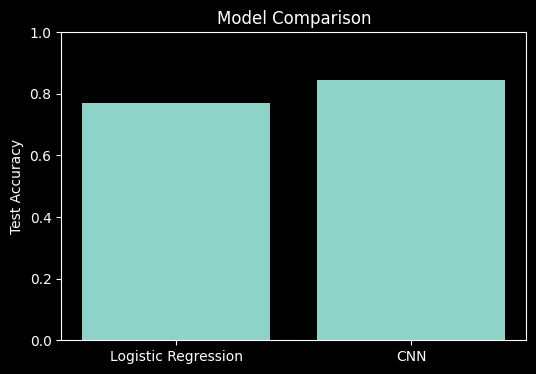

In [7]:
models = ["Logistic Regression", "CNN"]
accuracies = [baseline_accuracy, cnn_accuracy]

plt.figure(figsize=(6, 4))
plt.bar(models, accuracies)
plt.ylabel("Test Accuracy")
plt.title("Model Comparison")
plt.ylim(0, 1)
plt.show()

## Confusion Matrix Comparison

Confusion matrices provide additional insight into the types of errors made by
each model.

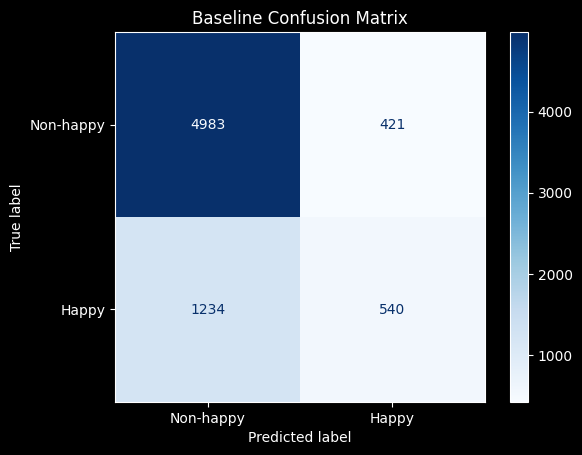

In [8]:
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
disp_baseline = ConfusionMatrixDisplay(
    confusion_matrix=cm_baseline,
    display_labels=["Non-happy", "Happy"]
)
disp_baseline.plot(cmap="Blues")
plt.title("Baseline Confusion Matrix")
plt.show()

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step


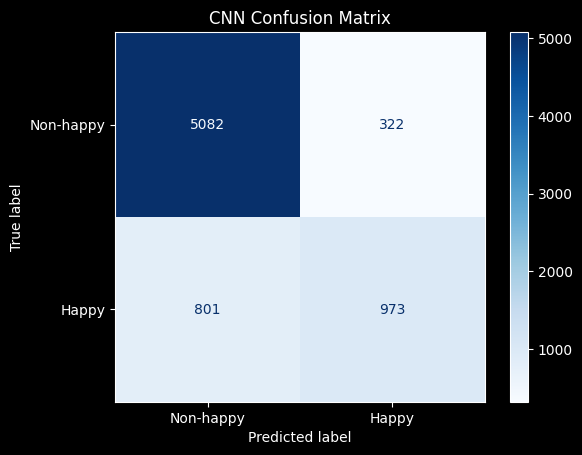

In [9]:
y_pred_cnn = (cnn_model.predict(X_test_cnn) > 0.5).astype(int).ravel()

cm_cnn = confusion_matrix(y_test, y_pred_cnn)
disp_cnn = ConfusionMatrixDisplay(
    confusion_matrix=cm_cnn,
    display_labels=["Non-happy", "Happy"]
)
disp_cnn.plot(cmap="Blues")
plt.title("CNN Confusion Matrix")
plt.show()

## Interpretation

- The CNN achieves higher test accuracy than the logistic regression baseline.
- Preserving spatial structure significantly reduces false negatives.
- The improvement aligns with the error patterns observed during baseline error
  analysis.

These results confirm that spatially aware models are better suited for facial
expression recognition.

## Conclusion

The comparison demonstrates that even a minimal convolutional neural network
provides a clear advantage over classical methods for this task. This validates
the model selection strategy and completes the core experimental pipeline of
the project.